In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,LSTM,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os
import heapq
import matplotlib.pyplot as plt


In [42]:
from google.colab import files
upload=files.upload()

Saving pg1513.txt to pg1513 (2).txt


In [43]:
file = open("pg1513.txt","r",encoding="utf8")
#store file in list
lines=[]
for i in file:
  lines.append(i)
#convert list tp string
data=""
for i in lines:
  data=' ' .join(lines) 

data=data.replace('\n','').replace('\r','').replace('\ufeff','').replace('"','').replace('"','')
#remove space
data=data.split()
data=' '.join(data)
data[:500]

'The Project Gutenberg eBook of Romeo and Juliet, by William Shakespeare This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before usi'

In [44]:
len(data)

160199

In [45]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts([data])

pickle.dump(tokenizer,open('token.pkl','wb'))

sequence_data=tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1, 53, 49, 306, 6, 12, 2, 22, 32, 967, 783, 16, 306, 8, 18]

In [46]:
len(sequence_data)

29352

In [47]:
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

4282


In [48]:
sequences=[]
for i in range(3,len(sequence_data)):
  words=sequence_data[i-3:i+1]
  sequences.append(words)


print("The length of sequences are:",len(sequences))
sequences=np.array(sequences)
sequences[:10]


The length of sequences are: 29349


array([[  1,  53,  49, 306],
       [ 53,  49, 306,   6],
       [ 49, 306,   6,  12],
       [306,   6,  12,   2],
       [  6,  12,   2,  22],
       [ 12,   2,  22,  32],
       [  2,  22,  32, 967],
       [ 22,  32, 967, 783],
       [ 32, 967, 783,  16],
       [967, 783,  16, 306]])

In [49]:
X=[]
y=[]
for i in sequences:
   X.append(i[0:3])
   y.append(i[3])

X=np.array(X)  
y=np.array(y) 

In [50]:
print("Date:",X[:10])
print("Response",y[:10])

Date: [[  1  53  49]
 [ 53  49 306]
 [ 49 306   6]
 [306   6  12]
 [  6  12   2]
 [ 12   2  22]
 [  2  22  32]
 [ 22  32 967]
 [ 32 967 783]
 [967 783  16]]
Response [306   6  12   2  22  32 967 783  16 306]


In [51]:
y=to_categorical(y,num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [52]:
# create the model

model = Sequential()
model.add(Embedding(vocab_size,10,input_length=3))
model.add(LSTM(1000,return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000,activation="relu"))
model.add(Dense(vocab_size,activation="softmax"))

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 10)             42820     
                                                                 
 lstm_4 (LSTM)               (None, 3, 1000)           4044000   
                                                                 
 lstm_5 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense_4 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_5 (Dense)             (None, 4282)              4286282   
                                                                 
Total params: 17,378,102
Trainable params: 17,378,102
Non-trainable params: 0
_________________________________________________________________


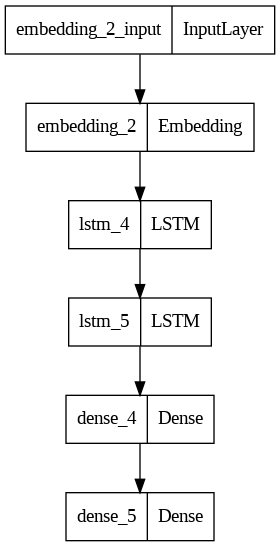

In [54]:
#plot the model

from tensorflow import keras
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(model,to_file='plot.png',show_layer_names=True)

In [57]:
#built our model

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint=ModelCheckpoint("next_words.h5",monitor='loss',verbose=1,save_best_only=True)
model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001))
model.fit(X,y, epochs=20,batch_size=64,callbacks=[checkpoint])

Epoch 1/20
459/459 [==============================] - ETA: 0s - loss: 1.7341
Epoch 1: loss improved from inf to 1.73408, saving model to next_words.h5
459/459 [==============================] - 15s 22ms/step - loss: 1.7341
Epoch 2/20
459/459 [==============================] - ETA: 0s - loss: 1.4221
Epoch 2: loss improved from 1.73408 to 1.42212, saving model to next_words.h5
459/459 [==============================] - 7s 15ms/step - loss: 1.4221
Epoch 3/20
459/459 [==============================] - ETA: 0s - loss: 1.2600
Epoch 3: loss improved from 1.42212 to 1.26001, saving model to next_words.h5
459/459 [==============================] - 7s 16ms/step - loss: 1.2600
Epoch 4/20
459/459 [==============================] - ETA: 0s - loss: 1.1212
Epoch 4: loss improved from 1.26001 to 1.12124, saving model to next_words.h5
459/459 [==============================] - 7s 15ms/step - loss: 1.1212
Epoch 5/20
459/459 [==============================] - ETA: 0s - loss: 0.9768
Epoch 5: loss improved

In [58]:
#prediction
from tensorflow.keras.models import load_model
import numpy as np
import pickle

model=load_model('next_words.h5')
tokenizer=pickle.load(open('token.pkl','rb'))

def Predict_Next_Words(model,tokenizer,text):
  sequence=tokenizer.texts_to_sequences([text])
  sequence=np.array(sequence)
  preds=np.argmax(model.predict(sequence))
  predicted_word=""
  for key,value in tokenizer.word_index.items():
    if value == preds:
      predicted_word =key
      break

  print(predicted_word)  
  return(predicted_word)  

In [59]:
while (True):
  text=input("Enter your lines:")

  if text == "0":
    print("Execution completed..")
    break

  else:
    try:
      text=text.split(" ")  
      text=text[-3:]
      print(text)
      Predict_Next_Words(model,tokenizer,text)

    except Exception as e:
      print("Error occured:",e)  
      continue

Enter your lines:Where civil blood
['Where', 'civil', 'blood']
1/1 [==============================] - 1s 625ms/step
makes
Enter your lines:A pair of star
['pair', 'of', 'star']
1/1 [==============================] - 0s 20ms/step
cross’d
Enter your lines:Doth with their
['Doth', 'with', 'their']
1/1 [==============================] - 0s 20ms/step
death
Enter your lines:0
Execution completed..
